# Twitter Hate Speech Detection

## *Can Content Moderation Be Automated?*

![banner](./visualizations/banner.png)


# Overview

This project aims to **automate content moderation** to identify hate speech using **machine learning binary classification algorithms.** Baseline models included Random Forest, Naive Bayes, Logistic Regression and Support Vector Machine (SVM). The final model was a Linear SVM model with an F1 of 0.3955 and Recall (TPR) of 0.4373. This poor performance can be attributed to the massive class imbalance and the model's inability to "understand" the nuances of English slang and slurs. Ultimately, automating hate speech detection is an extremely difficult task. And although this project was able to get that process started, there is much more work to be done in order to keep this content off of public-facing forums such as Twitter.

An **interactive version** of the final model is hosted on Heroku. Check it out [here](https://hate-speech-predictor.herokuapp.com/)!

# Business Problem

Human content moderation exploits people by consistently traumatizing and underpaying them. In 2019, an [article](https://www.theverge.com/2019/6/19/18681845/facebook-moderator-interviews-video-trauma-ptsd-cognizant-tampa) on The Verge exposed the extensive list of horrific working conditions that employees faced at Cognizant, which was Facebook’s primary moderation contractor. Unfortunately, every major tech company, including Twitter, uses human moderators to some extent, both domestically and overseas.

Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction. 

Any company with an online forum where users post content could benefit from automating as much as the moderation process as possible. Ultimately, human content moderation is not only detrimental to workers, but also presents a liability to companies that use them.

**Warning:** This notebook contains offensive language from the dataset.

# Data & Methods

The dataset for this capstone project was sourced from a study called *Automated Hate Speech Detection and the Problem of Offensive Language* conducted by Thomas Davidson and a team at Cornell University in 2017. The GitHub repository can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). The dataset is provided as a `.csv` file with 24,802 text posts from Twitter where **6% of the tweets were labeled as hate speech**. 

Since content moderation is so subjective, the labels on this dataset were voted on by crowdsource and determined by majority-rules. The “class” column labels each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. In order to create a different project and adapt the data to my specific business context, I will be treating the data as a binary classification problem. 

Therefore, the final model will be **predicting whether a tweet is hate speech or not.** To prepare the data for this, I will be manually replacing existing 1 and 2 values as 0, and replacing 0 as 1 to indicate hate speech.

# Data Understanding

### 1. What are the linguistic differences between hate speech and offensive language?

![img1](./visualizations/label_word_count_y.png)

The code for this graph can be found in [`eda_notebook.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/eda_notebook.ipynb).

Linguistically, it's important to note that the difference between hate speech and offensive language often comes down to how it targets marginalized communities, often in threatening ways.

Although these graphs have very similar frequently occurring words, there are a few that stand out. For instance, we can notice from this figure that Hate Speech typically contains the N-word with the hard 'R'. **The use of this slur could indicate malicious intent, which goes beyond possibly using the word as slang.**

Examples like that one demonstrate the nuances of English slang and the fine line between Hate Speech and offensive language. **Because of the similarities of each label’s vocabulary, it could be difficult for machine learning algorithms to differentiate between them and determine what counts as Hate Speech.**

### 2. What are the most popular hashtags of each tweet type?

![img2](./visualizations/censored_top_hashtags.png)

The code for this graph can be found in [`censored_hashtags.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/censored_hashtags.ipynb).

From these word clouds, we can see some more parallels and differences between what is classified as hate speech or not. For instance, #tcot stands for "Top Conservatives On Twitter” and it appears in both groups. However, #teabagger, which refers to those who identify with the Tea Party, that is primarily (but not exclusively) associated with the Republican Party, appears in only the “Not Hate Speech” cloud. Both hashtags are used among Alt-Right communities.

Additionally, the #r**skins hashtag appears in only the "Not Hate Speech" cloud. This was the former name of the Washington NFL team. Knowing the context, we know that hashtag could certainly include text that constitutes as hate speech. With this, and other hashtags that appear in the “Not Hate Speech” cloud, we can clearly see the very slight differences between the two labels.

Besides that, others are simply pop culture references, such as #Scandal the TV show or #vote5sos referring to the boy band. It’s interesting that those contain a lot of offensive language, probably from fan reactions and community conflicts. Ultimately, we can recommend that **Twitter should closely monitor those top hashtags for potential posts containing hate speech** or even regular offensive language.


### 3. What is the overall polarity of the tweets?

![img3](./visualizations/compound_polarity_score.png)


The code for this graph can be found in [`VADER_sentiment.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/VADER_sentiment.ipynb).

The compound polarity score is a metric that calculates the sum of all the [lexicon ratings](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt) which have been normalized between -1 and +1. With -1 being extreme negative and +1 being extreme positive. **This score encompasses the overall sentiment of this corpus.**

- Hate Speech tweets on average have a compound score of -0.363
- Non Hate Speech tweets on average have a compound score of -0.263

According to this metric, both classes of tweets have pretty negative sentiments because their normalized compound scores are less than the threshold of -0.05. 

Additionally from the graph above, we can see that tweets classified as Hate Speech are especially negative. This further emphasizes how slim the difference between the two labels are. Although both classes contain negative and offensive language, Hate Speech is much more negative on average.


![img3](./visualizations/avg_polarity_by_tweet_type.png)


The code for this graph can be found in [`VADER_sentiment.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/VADER_sentiment.ipynb).

To reiterate, this graph shows the average polarity scores for each label. Which are positive, neutral or negative. We can see that a majority were scored as neutral. However, of those that were scored as negative, it seems like "Not Hate Speech" had more on average. This is probably because of the class imbalance.

## Class Imbalance

The main roadblock of this dataset is the extreme class imbalance. We can see that only 5.77% of the data is labeled as hate speech. This could present challenges during the modeling process.

![imbalance](./visualizations/cleaned_class_imbalance.png)

The code for this graph can be found in [`data_cleaning.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/data_cleaning.ipynb).

***

In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import pickle
# custom fuctions
from src import helper_functions as helpers

# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn import metrics, utils, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

***

# Preprocessing Text Data

The original data from `twitter_data.csv` was cleaned using RegEx in the `data_cleaning.ipynb` notebook. 

**Cleaning Steps:**

- Reassigning labels
- Lowercasing tweet text
- Removing hashtags, mentions, quotes and punctuation from tweet text
- Checking for missing values

In [2]:
# loading in clean_df
clean_df = pd.read_pickle('./pickle/clean_df.pkl')

In [3]:
# previewing data
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...


From here, we'll be focusing on the `clean_tweets` column and the target variable, `label`.

## Tokenizing & Removing Stop Words

When working with text data, one of the first steps is to remove stop words from the corpus. Although text would be gramatically incorrect without these stop words, they provide little value to models and typically hinder performace.

We can use NLTK's built-in library of stop words to remove them in a tokenizing function.

Additionally, we tokenize text data so that machine learning algorithms can understand it.

In [4]:
# assigning variables to essential columns
data = clean_df['clean_tweets']
target = clean_df['label']

In [5]:
# setting NLTK stop words as `stop_words`
stop_words = set(stopwords.words('english'))

Next, we can use the `process_tweet` helper function, which tokenizes all the text and removes stop words.

In [6]:
# applying the above function to our `clean_tweets`
processed_data = list(map(helpers.process_tweet, data))

In [7]:
# getting count of all unique words in the corpus
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

20277

We can see that **the corpus has a vocabulary of 20,277 unique words**. This is useful to know because that will be the amount of columns in the sparse matrix after TF-IDF Vectorization. But we'll get to that step later.

## Top Words in Corpus

In [8]:
# transforming `processed_data` into a readable list
flat_filtered = [item for sublist in processed_data for item in sublist]
# getting frequency distribution
clean_corpus_freqdist = FreqDist(flat_filtered)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570),
 ('get', 1428),
 ('fuck', 1411),
 ('u', 1280),
 ('shit', 1262),
 ('nigga', 1198),
 ('aint', 1158),
 ('trash', 1142),
 ('lol', 1074),
 ('know', 806),
 ('niggas', 791)]

These top words are mostly offensive terms, and some other slang words that the NLTK stop words removal function didn't pick up.

For a breakdown of the top words in each label, refer to [`eda_notebook.ipynb'](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/eda_notebook.ipynb).

## Lemmatization

This last method reduces each word into a linguistically valid **lemma**, or **root word**. It does this through linguistic mappings, using the WordNet lexical database.


In [9]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [10]:
X_lem = lemmatized_output
y_lem = target

Now `X_lem` and `y_lem` are contain cleaned text and the original labels, ready to be used for modeling.

# Feature Engineering

## Train-Test Split
First, let's create a train-test split of the dataset, where 20% is reserved as unseen testing data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

## TF-IDF Vectorization

Before tokenized text data can be fed into machine learning models, they must be transformed into numerical feature vectors. First, we’ll be trying one of the most popular methods, TF-IDF Vectorization.

This is an acronym than stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This down scales words that appear a lot across documents.

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across other documents.

In [12]:
# using tf_idf vectorizor
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [13]:
# sparse matrix format with 20K stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

In [14]:
# taking a quick look of the non zero elements
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 13.364420457984465
Percentage of columns containing ZERO: 0.9998720483637183


99.9% of the columns contain a zero, meaning that's a very **sparse matrix** with 20K columns

***

# Modeling Process

## Evaluation Metrics

For this business problem, **we will use F1 score as the main metric**, while also looking at Precision and Recall. The F1 score finds the harmonic mean between Precision and Recall, and it's useful for data with high class imbalance.

**Overall, we want as much hate speech to flagged as possible** and so that it can be efficiently removed. This means **optomizing the True Positive Rate**.

### Weighted F1 Score

We will also be looking at the weighted F1 score, as it **can account for the class imbalance in labels by calculating metrics for each label**. It finds their average weighted by support (the number of true instances for each label). This results in a F1 score that is not between precision and recall.

### Cross Validation

Additionally, in order to see **whether a model is overfit or underfit**, we can use K-Fold Cross Validation to generate a F1 score for the training set. 

This method uses a limited sample in order to estimate how the model is expected to perform when making predictions on unseen data. For each model, 'K" aka the number of folds will be 5. This means that the data sample will be split into 5 groups and each used as the test set.

# Baseline Modeling

In this section we'll be running baseline Randon Forest, Logistic Regression, Naive Bayes and Support Vector Machine (SVM) models. Out of those 4 models, the best performing one will be selected to iterate through to achieve an MVP.

## Baseline Random Forest

A random forest model is an ensamble method that uses multiple Decision Trees to try to predict the output variable. Typically, it's one of the best performing models for classification problems.

In [15]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

Note that adding `class_weight='balanced'` actually increaased precision, but decreased F1. But we'll keep that hyperparameter in there, because it would need to be added eventually anyway, to deal with the huge class imabalnce in this dataset.

⏳ the cell below takes about 38 seconds to run

In [16]:
%%time
rf_baseline.fit(tfidf_data_train, y_train)
rf_test_preds = rf_baseline.predict(tfidf_data_test)

CPU times: user 37.3 s, sys: 278 ms, total: 37.6 s
Wall time: 38 s


In [17]:
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

# printing scores
helpers.evaluation(rf_precision, rf_recall, rf_f1_score, rf_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.4128
Recall: 0.1613
F1 Score: 0.232
Weighted F1 Score: 0.9272


These scores are not ideal becuase the F1 is being brought down on how the model predicts the "Hate Speech" label. The weighted F1 score mostly shows how the model is predicting the majority class, "Not Hate Speech". From here, we should try models with class imbalance methods to try and get the uniform F1 to improve.

As mentioned, we can take the cross validated F1 for the training set to determine whether the model is overfit or underfit.

⏳ the cell below takes about 9 minutes to run

In [18]:
%%time
# training f1
rf_f1_cv = cross_val_score(rf_baseline, tfidf_data_train, y_train, scoring='f1', cv=5)
rf_mean_cv = round(rf_f1_cv.mean(), 6)

CPU times: user 8min 23s, sys: 1.79 s, total: 8min 25s
Wall time: 8min 27s


In [19]:
# is this model overfit or underfit?
rf_fit = helpers.model_fit(rf_mean_cv, rf_f1_score)
rf_fit

'underfit'

### Overfit vs. Underfit

Above, I used a custom function to streamline the process. For instance, when a model's training metrics are higher than its testing metrics, then it is overfit.

Generally, a slightly underfit model is preferred. This means that the model is not too specific to the training data, and it should be able to generalize well on unseen data.

We can continue to run this custom fuction on future iterations to determine each model's fit. We can also store the testing set evaluation metrics for each model into a dictionary, and print them later for comparison.

In [20]:
# creating dictionary to store all metrics
metric_dict = {}
# adding scores to metric_dict
metric_dict['Baseline Random Forest'] = {'precision': rf_precision, 'recall': rf_recall, 'f1_score': rf_f1_score, 'weighted_f1': rf_f1_weighted, 'fit': rf_fit}

## Baseline Logistic Regression

Logistic Regression is another common model used for clasification tasks. Additionally, this model tends to work better with larger datasets.

In [21]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

I added `class_weight='balanced'` again, but this actually didn't impact the score. So we'll keep that hyperparamter. Also note that the penality is set to `L2`, but that's already the default.

⏳ the cell below takes about 3 seconds to run

In [22]:
%%time
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

CPU times: user 2.9 s, sys: 69.4 ms, total: 2.97 s
Wall time: 873 ms


In [23]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_f1_weighted = f1_score(y_test, logreg_test_preds, average='weighted')

# printing scores
helpers.evaluation(logreg_precision, logreg_recall, logreg_f1_score, logreg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2939
Recall: 0.5699
F1 Score: 0.3878
Weighted F1 Score: 0.9134


Compared the the first Random Forest baseline, the Logistic Regression baseline performed much better. The F1 score increased from 0.232 to 0.3878.

Although, this F1 score could still be increased. Before deciding on the model to iterate on, let's try Naive Bayes and SVM baselines first.

⏳ the cell below takes about 13 seconds to run

In [24]:
%%time
# training f1
log_reg_f1_cv = cross_val_score(logreg_baseline, tfidf_data_train, y_train, scoring='f1', cv=5)
log_reg_mean_cv = round(log_reg_f1_cv.mean(), 6)

CPU times: user 13.8 s, sys: 290 ms, total: 14.1 s
Wall time: 3.79 s


In [25]:
# is this model overfit or underfit?
log_reg_fit = helpers.model_fit(log_reg_mean_cv, logreg_f1_score)
log_reg_fit

'overfit'

In [26]:
# adding scores to metric_dict
metric_dict['Baseline Logisitic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score, 'weighted_f1': logreg_f1_weighted, 'fit': log_reg_fit}

## Baseline Naive Bayes

This model is another common baseline classification algorithm that uses Bayes Theorem with an assumption of independence between predictors. However, this assumption of independence is usually violated because the predictors are usually correlated to each other. That's where the "Naive" comes from.

Naive Bayes is a popular choice for text classification because it classifies based on the probabilities of events. Another pro is that this model takes less time to train.

In [27]:
baseline_bayes = MultinomialNB(alpha = .01)

⏳ the cell below takes about 11 milliseconds to run

In [28]:
%%time
baseline_bayes.fit(tfidf_data_train, y_train)
bayes_test_preds = baseline_bayes.predict(tfidf_data_test)

CPU times: user 10.2 ms, sys: 5.65 ms, total: 15.8 ms
Wall time: 16.5 ms


In [29]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
helpers.evaluation(bayes_precision, bayes_recall, bayes_f1_score, bayes_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.4118
Recall: 0.1254
F1 Score: 0.1923
Weighted F1 Score: 0.9255


The F1 score dropped down to .1923. So, this model performed worse than both the Random Forest and Logistic Regression models. This is surprising because Naive Bayes typically performs pretty well with text data. This could indicate that preprocessing steps could be improved.

For now, let's try the last baseline and decide which model to iterate on.

⏳ the cell below takes about 55 milliseconds to run

In [30]:
%%time
# training f1
bayes_f1_cv = cross_val_score(baseline_bayes, tfidf_data_train, y_train, scoring='f1', cv=5)
bayes_mean_cv = round(bayes_f1_cv.mean(), 6)

CPU times: user 54.9 ms, sys: 7 ms, total: 61.9 ms
Wall time: 60.9 ms


In [31]:
bayes_fit = helpers.model_fit(bayes_mean_cv, bayes_f1_score)
bayes_fit

'underfit'

In [32]:
# adding scores to metric_dict
metric_dict['Baseline Naive Bayes'] = {'precision': bayes_precision, 'recall': bayes_recall, 'f1_score': bayes_f1_score, 'weighted_f1': bayes_f1_weighted, 'fit': bayes_fit}

## Baseline Support Vector Machine (SVM)

An SVM is a type of classifier that modifies the loss function for optimization to not only take into account overall accuracy metrics of the resulting predictions, but also to maximize the decision boundary between the data points. Essentially, this further helps tune the classifier as a good balance between underfitting and overfitting.

A notable hyperparameter is the Kernel, which reprojects data onto a new parameter space using combinations of existing features. From there, the same process of applying SVMs to this transformed space can then be employed. This could provide more complex boundaries than just Linear.

For now, let's try an SVM with a Linear kernel as a baseline.

In [33]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

Notice that you can also add `class_weight='balanced'` to SVM models. This can help preemptively deal with the huge class imabalance in this dataset.

⏳ the cell below takes about 1 minute to run

In [34]:
%%time 
# fit the training dataset on the classifier
SVM_baseline.fit(tfidf_data_train, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(tfidf_data_test)

CPU times: user 49.3 s, sys: 573 ms, total: 49.9 s
Wall time: 50 s


In [35]:
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_f1_weighted = f1_score(y_test, SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.3609
Recall: 0.4373
F1 Score: 0.3955
Weighted F1 Score: 0.9281


This model produced the highest F1 so far, with a score of .3955. Next, let's look at the performance of all baselines all together, and move forward with a single model to iterate on. 

⏳ the cell below takes about 3 minutes to run

In [36]:
%%time
# training f1
base_SVM_f1_cv = cross_val_score(SVM_baseline, tfidf_data_train, y_train, scoring='f1', cv=5)
base_SVM_mean_cv = round(base_SVM_f1_cv.mean(), 6)

CPU times: user 2min 21s, sys: 1.57 s, total: 2min 23s
Wall time: 2min 23s


In [37]:
# is this model overfit or underfit?
base_SVM_fit = helpers.model_fit(base_SVM_mean_cv, SVM_f1_score)
base_SVM_fit

'underfit'

In [38]:
# adding scores to metric_dict
metric_dict['Baseline SVM'] = {'precision': SVM_precision, 'recall': SVM_recall, 'f1_score': SVM_f1_score, 'weighted_f1': SVM_f1_weighted, 'fit': base_SVM_fit}

## Evaluation Metrics for All Baseline Models

In [39]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM,0.360947,0.437276,0.395462,0.928112,underfit


It's a pretty close call between the Logisitic Regression and SVM baselines. But overall, the **Linear SVM model** performed the best across both uniform and weighted F1. However, there is still work to be done to bring that score up higher. 

Next we'll try improving that model with other feature engineering techniques, class imbalance remedy methods and tuning hyperparameters with grid search.

***

# Doc2Vec

One disadvantage to using Count Vectorization or TF-DF Vectorization is that we can run into the Curse of Dimensionality, which occurs when the number of features explodes. This problem happens because these methods create Sparse Vectors, that are the length of the total vocabulary of the text corpus. 

This corpus has a vocabulary of 20,277. Therefore, that's the number of columns in the Sparse Matrix, creating a ton of extra space of 99% 0s could possibly hurt the model. 

We can try Doc2Vec feature engineering, which is an extension of Word2Vec. It aims to learn how to project a document into a latent d-dimensional space. Specifically, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output.

In [12]:
# fresh TTS for doc2vec data
doc_train, doc_test = train_test_split(clean_df, test_size=0.3, random_state=42)

## Data Preparation

After performing a fresh train test split of the original dataframe, the next step is tokenizing the text as usual. Again, we can do this with NLTK.

The lambda function below will tokenize both the training and test set and tag each tweet with its label, "Hate Speech" or "Not Hate Speech."

In [14]:
# tagging training set
tagged_train = doc_train.apply(
    lambda r: TaggedDocument(words=helpers.tokenize_text(r['clean_tweets']), tags=[r.label]), axis=1)
# tagging testing set
tagged_test = doc_test.apply(
    lambda r: TaggedDocument(words=helpers.tokenize_text(r['clean_tweets']), tags=[r.label]), axis=1)

Let's take a look an example of a tagged tweet.

In [15]:
tagged_train.values[30]

TaggedDocument(words=['this', 'bitch', 'instating', 'and', 'driving', 'for', 'me'], tags=[0])

Here, you can see that this "Not Hate Speech" tweet has been tokenized and tagged with a `0` label.

## Training DBOW Model

As mentioned before, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output. It's similar to the Skip-gram model in Word2Vec. You can read more about the model in its documentation [here](https://radimrehurek.com/gensim/models/doc2vec.html).

The hyperparameters we'll use are as follows:
- `vector_size`: dimensionality of the feature vectors
- `alpha`: initial learning rate
- `min_count`: ignores all words with total frequency lower than this
- `dm`: defines the training algorithm; when dm=1, 'distributed memeory' (PV-DVM) is used
- `epochs`: number of iterations (epochs) over the corpus, defaults to 10 for Doc2Vec

In [16]:
# instantiating a doc2vec DBOW model
dbow_model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)

In [17]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# building vocabulary 
dbow_model.build_vocab([x for x in tqdm(tagged_train.values)])


100%|██████████| 17348/17348 [00:00<00:00, 2665694.09it/s]


Now that we have built a vocabulary, we can initialize the model and train it for 30 epochs.

⏳ the cell below takes about 26 seconds to run

In [18]:
%%time
for epoch in range(30):
    dbow_model.train(utils.shuffle([x for x in tqdm(tagged_train.values)]), total_examples=len(tagged_train.values), epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

100%|██████████| 17348/17348 [00:00<00:00, 2792232.46it/s]
CPU times: user 27.4 s, sys: 4.41 s, total: 31.9 s
Wall time: 24.1 s


## Applying Doc2Vec Data to Train SVM Baseline

The custom function `vec_for_learning` simply transforms the tagged tweets into vectors that are suitable for classification model use.

In [19]:
# train-test split
doc_y_train, doc_X_train = helpers.vec_for_learning(dbow_model, tagged_train)
doc_y_test, doc_X_test = helpers.vec_for_learning(dbow_model, tagged_test)

Next, we feed the Doc2Vec data into the previous Linear SVM model to see how this method compares.

In [20]:
# instantiating new SVM model
Doc2Vec_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

⏳ the cell below takes about 28 seconds to run

In [21]:
%%time
# fit the training dataset on the classifier
Doc2Vec_SVM.fit(doc_X_train, doc_y_train)

CPU times: user 26.4 s, sys: 312 ms, total: 26.7 s
Wall time: 26.9 s


SVC(class_weight='balanced', gamma='auto', kernel='linear')

In [22]:
# predict the labels on validation dataset
doc_SVM_y_preds = Doc2Vec_SVM.predict(doc_X_test)

In [23]:
doc_SVM_precision = precision_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_recall = recall_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_score = f1_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_weighted = f1_score(doc_y_test, doc_SVM_y_preds, average='weighted')

# printing scores
helpers.evaluation(doc_SVM_precision, doc_SVM_recall, doc_SVM_f1_score, doc_SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.1866
Recall: 0.5761
F1 Score: 0.2819
Weighted F1 Score: 0.8688


Unfortunately, using this method did not produce great results. It seems that it wasn't even able to predict the "Not Hate Speech" label as well as the other top-performing baselines. Let's compare it with other baselines next.

⏳ the cell below takes about 2 minutes to run

In [53]:
%%time
# training f1
doc_SVM_f1_cv = cross_val_score(Doc2Vec_SVM, doc_X_train, doc_y_train, scoring='f1', cv=5)
doc_SVM_mean_cv = round(doc_SVM_f1_cv.mean(), 6)

CPU times: user 1min 35s, sys: 980 ms, total: 1min 36s
Wall time: 1min 36s


In [54]:
# is this model overfit or underfit?
doc_SVM_fit = helpers.model_fit(doc_SVM_mean_cv, doc_SVM_f1_score)
doc_SVM_fit

'overfit'

Here, it's worth noting that the Doc2Vec method produced an overfit model. Whereas the TF-IDF vectorization method on the same exact Linear SVM model produced an underfit model.

In [55]:
metric_dict['Baseline SVM with Doc2Vec'] = {'precision': doc_SVM_precision, 'recall': doc_SVM_recall, 'f1_score': doc_SVM_f1_score, 'weighted_f1': doc_SVM_f1_weighted, 'fit': doc_SVM_fit}

## Comparing with Other Models

In [56]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM,0.360947,0.437276,0.395462,0.928112,underfit
Baseline SVM with Doc2Vec,0.178646,0.599532,0.275269,0.860716,overfit


As I just mentioned, the Doc2Vec model didn't perform as well as the Baseline Logisitc Regression or Linear SVM with TF-IDF Vectorization. 

Let's look at this closer with a classification report, to see how both SVM models predicted each label using the different vectorization methods.

## SVM Baselines: TF-IDF vs. Doc2Vec

In [57]:
target_names = ['class 0', 'class 1']
# Tf-IDF baseline
print('-'*14 + ' SVM Baseline with TF-IDF ' + '-'*13)
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
# Doc2Vec baseline
print('-'*13 + ' SVM Baseline with Doc2Vec ' + '-'*13)
print(classification_report(doc_y_test, doc_SVM_y_preds, target_names=target_names))

-------------- SVM Baseline with TF-IDF -------------
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

------------- SVM Baseline with Doc2Vec -------------
              precision    recall  f1-score   support

     class 0       0.97      0.83      0.90      7008
     class 1       0.18      0.60      0.28       427

    accuracy                           0.82      7435
   macro avg       0.58      0.72      0.59      7435
weighted avg       0.93      0.82      0.86      7435



As suspected, based on the F1 scores, the Doc2Vec method wasn't able to predict both the 1 or 0 label as well as the TF-IDF Vectorized model.

Let's go back to the original Linear SVM and try other class imbalance remedy methods to improve the scores.

***

# Dealing with Class Imbalance

The initial SVM Baseline dealt with class imbalance with the parameter `class_weight='balanced'`. Let's try other class imbalance remedy methods to improve the baseline, before tuning hyperparameters with grid search.

## Over-Sampling with SMOTE
This method over-samples the minority class, "Hate Speech".

Rather than simply oversampling the minority class with replacement (which adds duplicate cases to the dataset), the algorithm generates new sample data by creating ‘synthetic’ examples that are combinations of the closest minority class cases.

After synthetically resampling our data, we no longer need to lean on penalized class weights in order to improve our model tuning.

![smote](./visualizations/smote.png)

In [58]:
# generating new sample data from original TF-IDF vectorized data
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [59]:
# feeding in baseline SVM
smote_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

⏳ the cell below takes about 4 minutes to run

In [60]:
%%time
smote_SVM.fit(smote_X_train, smote_y_train)
smote_SVM_test_preds = smote_SVM.predict(tfidf_data_test)

CPU times: user 3min 43s, sys: 894 ms, total: 3min 44s
Wall time: 3min 44s


In [61]:
smote_precision = precision_score(y_test, smote_SVM_test_preds)
smote_recall = recall_score(y_test, smote_SVM_test_preds)
smote_f1_score = f1_score(y_test, smote_SVM_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(smote_precision, smote_recall, smote_f1_score, smote_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.3393
Recall: 0.2724
F1 Score: 0.3022
Weighted F1 Score: 0.9255


Seems that the uniform F1 score went down with SMOTE, from 0.395462 to 0.3022. Let's see how the model performs with Tomek Links instead.

⏳ the cell below takes about 11 minutes to run

In [62]:
%%time
# training f1
smote_f1_cv = cross_val_score(smote_SVM, smote_X_train, smote_y_train, scoring='f1', cv=5)
smote_f1_mean_cv = round(smote_f1_cv.mean(), 6)

CPU times: user 10min 56s, sys: 3.15 s, total: 10min 59s
Wall time: 11min


In [63]:
# is this model overfit or underfit?
smote_fit = helpers.model_fit(smote_f1_mean_cv, smote_f1_score)
smote_fit

'overfit'

In [64]:
# adding these metrics to evaluation metric dict
metric_dict['SVM Oversampled with SMOTE'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score, 'weighted_f1': smote_weighted_f1_score, 'fit': smote_fit}

## Under-Sampling with Tomek Links
This method under-samples the majoirty class, "Not Hate Speech."

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![tomek](./visualizations/tomek_links.png)

In [65]:
# resampling original TF-IDF vectorized data
tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18627, 1: 1151})


It only removed 48 values from the majority class.

In [66]:
tomek_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

⏳ the cell below takes about 43 seconds to run

In [67]:
%%time
tomek_SVM.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_SVM.predict(tfidf_data_test)

CPU times: user 40.5 s, sys: 589 ms, total: 41 s
Wall time: 41.3 s


In [68]:
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_logreg_test_preds, average='weighted')

# printing scores
helpers.evaluation(tomek_precision, tomek_recall, tomek_f1_score, tomek_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.6562
Recall: 0.2258
F1 Score: 0.336
Weighted F1 Score: 0.938


Although using Tomek Links performed better than using SMOTE, the resulting F1 still isn't as good as the baseline SVM's F1 score of 0.395462.

⏳ the cell below takes about 2 minutes to run

In [69]:
%%time
# training f1
tomek_f1_cv = cross_val_score(tomek_SVM, tomek_X_train, tomek_y_train, scoring='f1', cv=5)
tomek_mean_cv = round(tomek_f1_cv.mean(), 6)

CPU times: user 1min 50s, sys: 1.59 s, total: 1min 52s
Wall time: 1min 52s


In [70]:
# is this model overfit or underfit?
tomek_fit = helpers.model_fit(tomek_mean_cv, tomek_f1_score)
tomek_fit

'underfit'

In [71]:
# adding these metrics to evaluation metric dict
metric_dict['SVM Undersampled with Tomek Links'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score, 'weighted_f1': tomek_weighted_f1_score, 'fit': tomek_fit}

### Comparing SMOTE and Tomek Link models with others that used `class_weight='balanced'`

In [72]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM,0.360947,0.437276,0.395462,0.928112,underfit
Baseline SVM with Doc2Vec,0.178646,0.599532,0.275269,0.860716,overfit
SVM Oversampled with SMOTE,0.339286,0.272401,0.302187,0.925527,overfit
SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993,underfit


- The baseline SVM with `class_weight=balanced` has the highest uniform F1 score of 0.395462
- The undersampled baseline has a lower uniform F1, but higher weighted F1

We can take a look at each model's classification report to get a better idea about what's happening.

In [73]:
target_names = ['class 0', 'class 1']
# class_weight='balanced' Baseline report
print('-'*9 + ' SVM with `class_weight=balanced` ' + '-'*10)
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
print('-'*9 + ' SVM Undersampled with Tomek Links ' + '-'*9)
# Undersampled Baseline report
print(classification_report(y_test, tomek_logreg_test_preds, target_names=target_names))

--------- SVM with `class_weight=balanced` ----------
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

--------- SVM Undersampled with Tomek Links ---------
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      4678
     class 1       0.66      0.23      0.34       279

    accuracy                           0.95      4957
   macro avg       0.81      0.61      0.65      4957
weighted avg       0.94      0.95      0.94      4957



There are some differances. But most noteably, the baseline with `class_weight=balanced` predicts the hate speech (1) class much better than the other model. It's able to predict 40% compared to the other model's 34%.

However, 40% still isn't good enough! Next, we need to use grid search to improve the baseline Linear SVM's hyperparameters.

***

# Grid Search

The `sklearn` library provides an easy way to tune model parameters through an exhuastive search using `GridSearchCV`. It combines K-Fold Cross Validation with a grid search of hyperparameters.

A full list of an SVC model's hyperparameters can be found in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

With this grid search, I aimed to improve the C and Gamma, and seeing if any other kernels outperform the Linear kernel.

- More information about selecting the right C and gamma can be found in [this](https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine) Quora post.
- More information about selecting the right SVM Kernel can be found in [this](https://towardsdatascience.com/svm-and-kernel-svm-fed02bef1200) TowardsDataScience article.

The following hyperparamter dictionary was used and the grid search took about **48 minutes** to run. 

**Grid Searched Parameters:**
- 'C': [1, 10, 100]
- 'gamma': [0.1, 0.01, 0.001]
- 'kernel': ['rbf', 'sigmoid']

For the sake of reproducibility, the tuned model is below. The full code can be found in the `SVM.ipynb` notebook.

In [74]:
# tuned model
grid_SVM = svm.SVC(C=1, class_weight='balanced', gamma=0.1, kernel='rbf', random_state=20)

⏳ the cell below takes about **40 seconds** to run

In [75]:
%%time
# fit the model to our training data
grid_SVM.fit(tfidf_data_train, y_train)

CPU times: user 38.5 s, sys: 356 ms, total: 38.9 s
Wall time: 39.1 s


SVC(C=1, class_weight='balanced', gamma=0.1, random_state=20)

In [76]:
# predict the training set
grid_SVM_test_preds = grid_SVM.predict(tfidf_data_test)

In [77]:
# setting variables for evaluation metrics
grid_precision = precision_score(y_test, grid_SVM_test_preds)
grid_recall = recall_score(y_test, grid_SVM_test_preds)
grid_f1_score = f1_score(y_test, grid_SVM_test_preds)
grid_weighted_f1_score = f1_score(y_test, grid_SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(grid_precision, grid_recall, grid_f1_score, grid_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.2808
Recall: 0.6129
F1 Score: 0.3851
Weighted F1 Score: 0.9083


This model still wasn't able to surpass the Linear SVM's F1 score of 0.395462. This is interesting because the Linear kernel's boundary usuaully isn't sufficient for separating two classes clearly. 

⏳ the cell below takes about 2 minutes to run

In [78]:
%%time
# training f1
grid_SVM_f1_cv = cross_val_score(grid_SVM, tfidf_data_train, y_train, scoring='f1', cv=5)
grid_SVM_mean_cv = round(grid_SVM_f1_cv.mean(), 6)

CPU times: user 1min 59s, sys: 1.3 s, total: 2min 1s
Wall time: 2min 1s


In [79]:
# is this model overfit or underfit?
grid_SVM_fit = helpers.model_fit(grid_SVM_mean_cv, grid_f1_score)
grid_SVM_fit

'overfit'

In [80]:
# adding these metrics to evaluation metric dict
metric_dict['Grid Search SVM'] = {'precision': grid_precision, 'recall': grid_recall, 'f1_score': grid_f1_score, 'weighted_f1': grid_weighted_f1_score, 'fit': grid_SVM_fit}

***

# Evaluating All Models

In [81]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM,0.360947,0.437276,0.395462,0.928112,underfit
Baseline SVM with Doc2Vec,0.178646,0.599532,0.275269,0.860716,overfit
SVM Oversampled with SMOTE,0.339286,0.272401,0.302187,0.925527,overfit
SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993,underfit
Grid Search SVM,0.280788,0.612903,0.385135,0.908306,overfit


After so many iterations, the Baseline Linear SVM model is the best performing model. Next, let's analyze this model's overall performance and how it applies to the business case.

***

# Final Model Analysis: Linear SVM

The best performing model is a Linear SVM model with `C=1.0`, `kernel='linear'`, `degree=3`, `gamma='auto'` and `class_weight='balanced'`.

## Pickling Final Model

The final Linear SVM model will be pickled for future use.

In [82]:
pickle_out = open("./pickle/final_linear_SVM.pkl","wb")
pickle.dump(SVM_baseline, pickle_out)
pickle_out.close()

## Testing Evaluation Metrics

In [83]:
helpers.evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.3609
Recall: 0.4373
F1 Score: 0.3955
Weighted F1 Score: 0.9281


As mentioned before, the uniform F1 score of .3955 is so low because it is brought down by the poor predicting ability for the "Hate Speech" label. We'll take a closer look at this later, and why that might be happening despite all the preprocessing steps and model iterations.

## Overfit or Underfit?

Although we already know that **this model is underfit**, Let's backtrack for a minute and **check by how much**.

In [95]:
# cross validated f1 score for training set
print('Training F1 Score: {:.5}'.format(base_SVM_mean_cv))
# uniform f1 score for testing set
print('Testing F1 Score: {:.5}'.format(SVM_f1_score))

Training F1 Score: 0.36768
Testing F1 Score: 0.39546


From this training metric, we can determine that the final model is only ** *slightly* underfit**.

Next, let's look at how the model was able to predict each label.

## Confusion Matrix

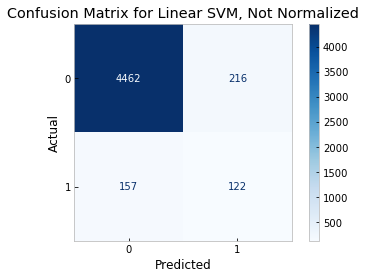

In [87]:
# generating standard confusion matrix
SVM_conf_matrix = plot_confusion_matrix(SVM_baseline, tfidf_data_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)
SVM_conf_matrix.ax_.set_title('Confusion Matrix for Linear SVM, Not Normalized')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./visualizations/not_normalized_svm_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

From this confusion matrix, we can see that the True Negative rate is alright, but the True Positive rate is really poor. Let's normalize these values to get a better sense of this relationship.

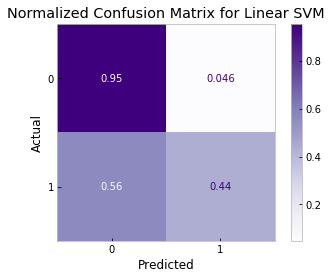

In [88]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(SVM_baseline, tfidf_data_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for Linear SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./visualizations/normalized_svm_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

So as expected, the final model has a True Negative Rate of 95% and a True Positive Rate of only 44%.

This is consistent with the final model's evaluation metrics, where it got a Recall of .437, aka the True Negative Rate. In this business context, we would ideally want as many True Negatives as possible, because that would be identifying Hate Speech correctly. Therefore, this is where the final model fails.

Also, we can see that only 4.6% of predictions are False Positives. Which mean that they were classified as "Hate Speech" when it's not. It's great that this amount is low, because site users tend to launch complaint reports when their content is over-flagged as hate speech content when it's not.

Overall, the Recall of this model needs to be greatly improved, in addition to the F1 of 0.3955.

***

# Conclusion

The final model had an F1 of .3955 and Recall of .437, which isn't much better than random guessing. Although this project had extensive preprocessing and modeling iterations, there is much room for improvement.

It's important to understand why the model performed so poorly and how that relates to the business problem. The F1 score was brought down by the "Hate Speech" label predictions. The model was able to predict 95% of the "Not Hate Speech" labels correctly, but it performed poorly for the other label, only able to correctly predict 44%. 

**This poor performance is indicative of the two major roadblocks of the project:** 

1. Massive class imbalance of the dataset
2. Model's inability to identify what constitutes as hate speech.

The issue of class imbalance is manageable with preprocessing techniques and oversampling/undersampling techniques. However, identifying hate speech is an overall problem that many major tech companies like Twitter, Facebook and Instagram are still struggling with.

This is because the line between Hate Speech and regular offensive language is so fine. Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction.

![venn](./visualizations/word_venn.png)

Here, we can see that there are **679 words unique to the "Hate Speech" label**. Some of these words are nonsensical or meaningless, but some are especially hateful terms. For example, this label contains phrases such as "sp-cs", "mo-kies", "ov-nj-w", "fa--ot" and much more. These are all ethnic or homophobic slurs. Most notably, we saw in earlier EDA that this label disproportionately contains the N-word with the hard "R". Language like this directly demonstrates hate speech by targeting marginalized groups.

However, it's hard for a machine learning model to understand the nuances with this hateful slang. **Although these words are unique to the "Hate Speech" label corpus, there's simply not enough data for that label.** Therefore, an important next step would be to collect more data that has been identified as hate speech by CrowFlow voters.

Additionally, we can recommend for now that Twitter **manually moderate tweets containing words**, just like it could with the top hashtags that were identified for each label in earlier EDA.

Ultimately, automating hate speech detection is an extremely difficult task because of the nuances in English slang and slurs. This project was able to get that process started, but there is much more work to be done to keep this content off of public-facing forums such as Twitter.

# Next Steps

To further develop this project, here are some immediate next steps that anyone could execute.

- Collect more potential "Hate Speech" data to be labeled by CrowdFlower voting system
- Improve final model with different preprocessing techniques, such as removing offensive language as stop words
- Evaluate model with new tweets or other online forum data to see if it can generalize well
- LDA Topic Modeling with Gensim